In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
import prep

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

wrangle.py functions loaded successfully
acquire.py functions loaded successfully


In [30]:
df = prep.prep_zillow_data()
df.describe()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusetypeid,logerror
count,21352.000000,21352.000000,21352.000000,21352.000000,21352.000000,21352.000000,21352.000000,21352.000000,2.135200e+04,2.135200e+04,...,21352.000000,21352.000000,2.135200e+04,2.135200e+04,21352.0,2.135200e+04,21352.000000,2.135200e+04,21352.000000,21352.000000
mean,2.304632,3.061727,2.322734,1800.447152,1776.715597,6049.393125,2.252219,3.955741,3.400427e+07,-1.182018e+08,...,1.108271,1968.261201,1.917828e+05,5.030912e+05,2016.0,3.116318e+05,6138.545271,6.049679e+13,261.675909,0.012698
std,0.994982,1.130032,0.973808,944.553063,914.233623,21.135638,0.958671,2.834390,2.670335e+05,3.616733e+05,...,0.370724,23.837674,2.367041e+05,6.505557e+05,0.0,4.688036e+05,7545.435503,2.093104e+11,3.805794,0.169943
min,0.000000,0.000000,1.000000,242.000000,242.000000,6037.000000,1.000000,1.000000,3.334085e+07,-1.193883e+08,...,1.000000,1824.000000,1.290000e+02,1.050400e+04,2016.0,2.250000e+03,19.920000,6.037101e+13,246.000000,-4.453964
25%,2.000000,2.000000,2.000000,1188.750000,1194.000000,6037.000000,2.000000,2.000000,3.380747e+07,-1.184140e+08,...,1.000000,1953.000000,8.500675e+04,2.108100e+05,2016.0,8.780000e+04,2739.842500,6.037311e+13,261.000000,-0.026735
50%,2.000000,3.000000,2.000000,1557.000000,1572.000000,6037.000000,2.000000,3.955741,3.401928e+07,-1.181780e+08,...,1.000000,1969.000000,1.387925e+05,3.652830e+05,2016.0,2.091910e+05,4523.675000,6.037621e+13,261.000000,0.004370
75%,3.000000,4.000000,3.000000,2137.000000,2063.000000,6059.000000,3.000000,3.955741,3.417543e+07,-1.179231e+08,...,1.108271,1987.000000,2.218638e+05,5.885595e+05,2016.0,3.812392e+05,7139.585000,6.059042e+13,265.000000,0.036181
max,11.000000,12.000000,11.000000,15450.000000,15450.000000,6111.000000,11.000000,24.000000,3.477966e+07,-1.175554e+08,...,4.000000,2015.000000,7.893568e+06,2.385837e+07,2016.0,1.635060e+07,276797.830000,6.111009e+13,275.000000,3.175688


In [3]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test(df)

In [4]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scale(X_train, X_validate, X_test)

In [5]:
X_train_scaled

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,...,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,censustractandblock,propertylandusetypeid
3927,0.272727,0.166667,0.20,0.182322,0.182322,0.297297,0.1,0.128510,0.084331,0.905312,...,0.0,0.003309,0.000000,0.03609,0.825503,0.040794,0.0,0.028981,0.296872,0.689655
19745,0.090909,0.166667,0.00,0.043299,0.043299,0.000000,0.0,0.260870,0.266832,0.683229,...,1.0,0.000840,0.000000,0.00000,0.563758,0.013765,0.0,0.026478,0.006444,0.517241
1732,0.227273,0.250000,0.15,0.103328,0.103328,0.297297,0.1,0.128510,0.096756,0.926589,...,0.0,0.003309,0.000000,0.03609,0.825503,0.016087,0.0,0.029037,0.296872,0.517241
17739,0.272727,0.250000,0.20,0.125783,0.125783,0.000000,0.2,0.043478,0.863848,0.660879,...,1.0,0.004435,0.000000,0.00000,0.845638,0.015576,0.0,0.001744,0.010947,0.517241
15673,0.090909,0.250000,0.00,0.063697,0.063697,0.000000,0.0,0.260870,0.395467,0.622926,...,1.0,0.000003,0.000000,0.00000,0.523490,0.002053,0.0,0.000747,0.001906,0.517241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11371,0.181818,0.166667,0.10,0.063607,0.063607,0.000000,0.1,0.043478,0.505266,0.656802,...,1.0,0.000135,0.000000,0.00000,0.778523,0.016798,0.0,0.013253,0.001356,0.689655
21006,0.272727,0.250000,0.20,0.106280,0.106280,0.000000,0.2,0.043478,0.618289,0.433740,...,1.0,0.001199,0.000000,0.00000,0.771812,0.030207,0.0,0.004726,0.000165,0.689655
20936,0.272727,0.416667,0.20,0.197531,0.197531,0.297297,0.2,0.128510,0.258997,0.788779,...,0.0,0.003319,0.571429,0.03609,0.724832,0.018350,0.0,0.031033,0.297502,0.517241
3675,0.090909,0.250000,0.00,0.069959,0.069959,0.000000,0.0,0.043478,0.323531,0.705201,...,1.0,0.000761,0.000000,0.00000,0.563758,0.010447,0.0,0.012499,0.006358,0.517241


In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

In [7]:
f_selector = SelectKBest(f_regression, k=5)

In [8]:
f_selector = f_selector.fit(X_train_scaled, y_train.taxvaluedollarcnt)

In [9]:
X_train_reduced = f_selector.transform(X_train_scaled)
print(X_train.shape)
print(X_train_reduced.shape)

(11956, 24)
(11956, 5)


In [10]:
f_support = f_selector.get_support()
f_support

array([False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False])

In [11]:
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt']

In [12]:
X_reduced_scaled = X_train_scaled.iloc[:, f_support]
X_reduced_scaled.head()

,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,structuretaxvaluedollarcnt,landtaxvaluedollarcnt
3927,0.20,0.182322,0.182322,0.040794,0.028981
19745,0.00,0.043299,0.043299,0.013765,0.026478
1732,0.15,0.103328,0.103328,0.016087,0.029037
17739,0.20,0.125783,0.125783,0.015576,0.001744
15673,0.00,0.063697,0.063697,0.002053,0.000747


In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [14]:
lm = LinearRegression()

rfe = RFE(lm, 5)

X_rfe = rfe.fit_transform(X_train,y_train) 

In [15]:
mask = rfe.support_ 
rfe_features = X_train.columns[mask]
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, fullbathcnt, unitcnt


In [16]:
lm.fit(X_rfe, y_train)

LinearRegression()

In [17]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression()
intercept:  [-61773.02196221]
features:  Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fullbathcnt',
       'unitcnt'],
      dtype='object')
coefficients:  [[-107490.87133675  -15138.47742158  513080.11947652  -48636.08233424
  -196665.88346906]]


In [18]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

,taxvaluedollarcnt,yhat_lm
3927,798178.0,809486.527745
19745,543907.0,68237.305531
1732,604073.0,591553.426253
17739,153848.0,767005.159721
15673,30802.0,53098.828110


In [42]:
RMSE_lm = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_lm))
RMSE_lm

620125.72322601

In [20]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

,taxvaluedollarcnt,yhat_lm
3927,798178.0,809486.527745
19745,543907.0,68237.305531
1732,604073.0,591553.426253
17739,153848.0,767005.159721
15673,30802.0,53098.828110


In [33]:
r2_lm = lm.score(X_rfe, y_train.taxvaluedollarcnt)

r2_lm

0.22371409539523923

In [34]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = -6.177e+04 + -1.1e+05 * bathroomcnt + -1.51e+04 * bedroomcnt'

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [24]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [35]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly))
RMSE_poly

580456.1633389734

In [26]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly
3927,798178.0,809486.527745,614572.45676
19745,543907.0,68237.305531,284036.45676
1732,604073.0,591553.426253,511244.45676
17739,153848.0,767005.159721,628524.45676
15673,30802.0,53098.828110,280748.45676


In [38]:
y_train['yhat_baseline'] = df['taxvaluedollarcnt'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_baseline))
print(RMSE_bl)

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.yhat_baseline)
print(evs)


703880.4241372065
1.1102230246251565e-16


In [28]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly,yhat_baseline
3927,798178.0,809486.527745,614572.45676,503091.195579
19745,543907.0,68237.305531,284036.45676,503091.195579
1732,604073.0,591553.426253,511244.45676,503091.195579
17739,153848.0,767005.159721,628524.45676,503091.195579
15673,30802.0,53098.828110,280748.45676,503091.195579


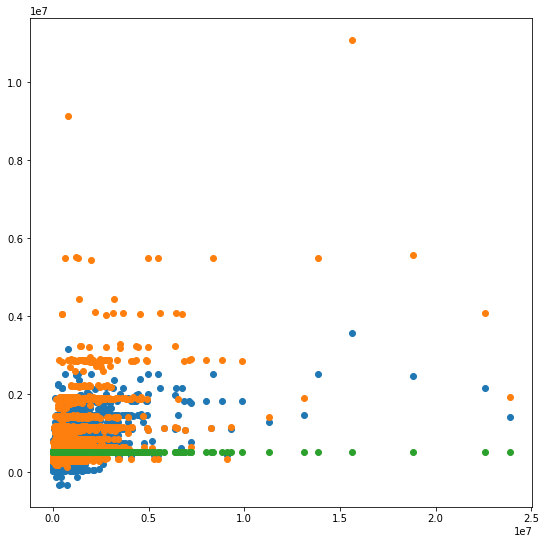

In [41]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_lm, marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_poly, marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, marker='o')